In [7]:
import numpy as np
import importlib
from sklearn.metrics import pairwise, normalized_mutual_info_score, adjusted_rand_score
import networkx as nx
from matplotlib import pyplot as plt
from optimize.functions import MSTER, loss, grad, H
from sklearn.cluster import KMeans
from config import MFConfig
import pandas as pd
from sklearn.decomposition import PCA
import copy

num_points = 300
num_clusters = 5
random_state = 1600

df = pd.read_csv('mnist_784_zip/data/mnist_784_csv.csv')
df = df.loc[df['class'].isin([0,1,4,6,8])]
df = df.sample(n=num_points, random_state=random_state)
labels = np.array(df['class'])
data = np.mat(df.drop('class', axis=1))

pca_0 = PCA(n_components = 30) #initial dim reduction for faster MST computation (from tSNE paper)
init_data = np.mat(pca_0.fit_transform(data))
(M, A, B, k_A, k_B, lr_a, lr_a_decay, lr_b, lr_b_decay, lambda_, lambda_decay, eta, eta_decay, num_epochs, clip_a, clip_b) = MFConfig(M=init_data).dump()

pca = PCA(n_components = 2)
pca_init = np.mat(pca.fit_transform(init_data))

def train():
    global M, A, B, k_A, k_B, lr_a, lr_a_decay, lr_b, lr_b_decay, lambda_, lambda_decay, eta, eta_decay, num_epochs, clip_a, clip_b
    A_best = A.copy()
    B_best = B.copy()

    ratio_A, vertices_A = MSTER(A, k_A)
    ratio_B, vertices_B = MSTER(B.T, k_B)
    loss_best = loss(M,A,B,ratio_A, ratio_B, lambda_, eta)
    losses = []
    for epoch in range(num_epochs):
        best = ''
        if (epoch%10)<5:
            gradient = (-(M-A*B)*B.T - lambda_*grad(A,vertices_A) - eta*(2*H(M.shape[0]).T*H(M.shape[0])*A))
            n = np.linalg.norm(gradient, ord='fro')
            if n > clip_a:
                gradient = clip_a * gradient/n

            A = A - lr_a*gradient
        else:
            gradient = (-A.T*(M-A*B))
            n = np.linalg.norm(gradient, ord='fro')
            if n > clip_b:
                gradient = clip_b * gradient/n

            B = B - lr_b*gradient #- lambda_*grad(B.T, vertices_B).T - eta*(2*B*H(M.shape[1]).T*H(M.shape[1])))

        ratio_A, vertices_A = MSTER(A, k_A)
        ratio_B, vertices_B = MSTER(B.T, k_B)
        loss_ = loss(M,A,B,ratio_A, ratio_B, lambda_, eta)
        losses.append(loss_)

        if loss_<loss_best:
            A_best = A.copy()
            B_best = B.copy()
            best = 'best'
            loss_best = loss_

        lr_a -= lr_a_decay
        lr_b -= lr_b_decay
        lambda_ -= lambda_decay
        eta -= eta_decay

        print("epoch {0} --- \t loss: {1} \t norm contribution: {2} \t {3}".format(epoch,
                loss_, 0.5*np.linalg.norm(M-A*B, ord = 'fro')**2, best))

    return A_best,B_best #returns best model in terms of loss

if __name__ == '__main__':
    A_best, B_best = train()

    ### Dim Reduction
    base = {1: [], 4: [], 6: [], 8: [], 0: []} #{1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: [], 0: []}
    base_kmeans = {0: [], 1: [], 2: [], 3:[], 4:[]}
    legend = [1,4,6,8,0]

    _dict = copy.deepcopy(base)
    for i,row in enumerate(np.array(A_best)):
        _dict[labels[i]].append(row)

    plt.figure(1)
    plt.title('d=2 MSTER-ALS Representation of MNIST Sample (n={})'.format(num_points))
    for i in _dict.keys():
        plt.scatter(np.array(_dict[i])[:,0], np.array(_dict[i])[:,1], alpha=0.6)
    plt.legend(legend)

    _dict2 = copy.deepcopy(base)
    for i,row in enumerate(np.array(pca_init)):
        _dict2[labels[i]].append(row)

    plt.figure(2)
    plt.title('d=2 PCA Representation of MNIST Sample (n={})'.format(num_points))
    for i in _dict2.keys():
        plt.scatter(np.array(_dict2[i])[:,0], np.array(_dict2[i])[:,1], alpha=0.6)
    plt.legend(legend)

    ### KMeans stuff

    predictions_MSTER = KMeans(n_clusters = num_clusters, random_state = random_state).fit(A_best).labels_
    predictions_PCA = KMeans(n_clusters = num_clusters, random_state = random_state).fit(pca_init).labels_

    plt.figure(3)
    plt.title('K-Means predictions for MSTER')
    _dict3 = copy.deepcopy(base_kmeans)
    for i,row in enumerate(np.array(A_best)):
        _dict3[predictions_MSTER[i]].append(row)
    for i in _dict3.keys():
        plt.scatter(np.array(_dict3[i])[:,0], np.array(_dict3[i])[:,1], alpha=0.6)
    plt.legend(range(10))

    plt.figure(4)
    plt.title('K-Means predictions for PCA')
    _dict4 = copy.deepcopy(base_kmeans)
    for i,row in enumerate(np.array(pca_init)):
        _dict4[predictions_PCA[i]].append(row)
    for i in _dict4.keys():
        plt.scatter(np.array(_dict4[i])[:,0], np.array(_dict4[i])[:,1], alpha=0.6)
    plt.legend(range(10))

    ### NMI
    score_MSTER = normalized_mutual_info_score(labels, predictions_MSTER)
    score_PCA = normalized_mutual_info_score(labels, predictions_PCA)

    print("MSTER NMI score: {} \n PCA NMI score: {}".format(score_MSTER, score_PCA))

    ### ARI
    score_MSTER = adjusted_rand_score(labels, predictions_MSTER)
    score_PCA = adjusted_rand_score(labels, predictions_PCA)

    print("MSTER Rand score: {} \n PCA Rand score: {}".format(score_MSTER, score_PCA))
    
    plt.plot(range(len(losses)),losses)

    plt.show()




M: (300, 30)
A: (300, 2)
B: (2, 30)
epoch 0 --- 	 loss: 409131313.76333666 	 norm contribution: 409060225.6959757 	 best
epoch 1 --- 	 loss: 408178589.81017166 	 norm contribution: 407936532.8519515 	 best
epoch 2 --- 	 loss: 407478057.0389384 	 norm contribution: 407007799.5310476 	 best
epoch 3 --- 	 loss: 406962452.490405 	 norm contribution: 406236456.26542497 	 best
epoch 4 --- 	 loss: 406582523.1814688 	 norm contribution: 405592936.4532549 	 best
epoch 5 --- 	 loss: 371985317.7645526 	 norm contribution: 370995731.0363387 	 best
epoch 6 --- 	 loss: 363153986.9472055 	 norm contribution: 362164400.2189916 	 best
epoch 7 --- 	 loss: 359753994.86376053 	 norm contribution: 358764408.1355466 	 best
epoch 8 --- 	 loss: 359376114.9141975 	 norm contribution: 358386528.1859836 	 best


KeyboardInterrupt: 

M: (100, 30)
A: (100, 2)
B: (2, 30)


/home/mstrals/MSTER-ALS-Matrix-Factorization/optimize/functions.py:131: RuntimeWarning: overflow encountered in ubyte_scalars
  diff1 = 2*len(A)*(A_[k]+B_[k])*x-np.sum(np.array([(A_[k]*B_[j]-B_[k]*A_[j])*A[j] for j in range(len(A))]))
/home/mstrals/MSTER-ALS-Matrix-Factorization/optimize/functions.py:132: RuntimeWarning: overflow encountered in ubyte_scalars
  diff2 = 2*len(A)*(C_[k]+D_[k])*x-np.sum(np.array([(C_[k]*D_[j]-D_[k]*C_[j])*A[j] for j in range(len(A))]))


epoch 0 --- 	 loss: 132204990.74980608 	 norm contribution: 153260946.17319432 	 best


/home/mstrals/MSTER-ALS-Matrix-Factorization/optimize/functions.py:131: RuntimeWarning: overflow encountered in ubyte_scalars
  diff1 = 2*len(A)*(A_[k]+B_[k])*x-np.sum(np.array([(A_[k]*B_[j]-B_[k]*A_[j])*A[j] for j in range(len(A))]))
/home/mstrals/MSTER-ALS-Matrix-Factorization/optimize/functions.py:132: RuntimeWarning: overflow encountered in ubyte_scalars
  diff2 = 2*len(A)*(C_[k]+D_[k])*x-np.sum(np.array([(C_[k]*D_[j]-D_[k]*C_[j])*A[j] for j in range(len(A))]))


epoch 1 --- 	 loss: 129493545.8513002 	 norm contribution: 154686675.16470468 	 best


/home/mstrals/MSTER-ALS-Matrix-Factorization/optimize/functions.py:131: RuntimeWarning: overflow encountered in ubyte_scalars
  diff1 = 2*len(A)*(A_[k]+B_[k])*x-np.sum(np.array([(A_[k]*B_[j]-B_[k]*A_[j])*A[j] for j in range(len(A))]))
/home/mstrals/MSTER-ALS-Matrix-Factorization/optimize/functions.py:132: RuntimeWarning: overflow encountered in ubyte_scalars
  diff2 = 2*len(A)*(C_[k]+D_[k])*x-np.sum(np.array([(C_[k]*D_[j]-D_[k]*C_[j])*A[j] for j in range(len(A))]))


epoch 2 --- 	 loss: 134441681.52066484 	 norm contribution: 153291732.84912202 	 


/home/mstrals/MSTER-ALS-Matrix-Factorization/optimize/functions.py:131: RuntimeWarning: overflow encountered in ubyte_scalars
  diff1 = 2*len(A)*(A_[k]+B_[k])*x-np.sum(np.array([(A_[k]*B_[j]-B_[k]*A_[j])*A[j] for j in range(len(A))]))
/home/mstrals/MSTER-ALS-Matrix-Factorization/optimize/functions.py:132: RuntimeWarning: overflow encountered in ubyte_scalars
  diff2 = 2*len(A)*(C_[k]+D_[k])*x-np.sum(np.array([(C_[k]*D_[j]-D_[k]*C_[j])*A[j] for j in range(len(A))]))


epoch 3 --- 	 loss: 141020298.00761998 	 norm contribution: 152277962.11556238 	 


/home/mstrals/MSTER-ALS-Matrix-Factorization/optimize/functions.py:131: RuntimeWarning: overflow encountered in ubyte_scalars
  diff1 = 2*len(A)*(A_[k]+B_[k])*x-np.sum(np.array([(A_[k]*B_[j]-B_[k]*A_[j])*A[j] for j in range(len(A))]))
/home/mstrals/MSTER-ALS-Matrix-Factorization/optimize/functions.py:132: RuntimeWarning: overflow encountered in ubyte_scalars
  diff2 = 2*len(A)*(C_[k]+D_[k])*x-np.sum(np.array([(C_[k]*D_[j]-D_[k]*C_[j])*A[j] for j in range(len(A))]))


epoch 4 --- 	 loss: 139793526.95634666 	 norm contribution: 151419289.6914315 	 
epoch 5 --- 	 loss: 135165078.12525085 	 norm contribution: 146790840.86033568 	 
epoch 6 --- 	 loss: 134824186.88615313 	 norm contribution: 146449949.62123796 	 
epoch 7 --- 	 loss: 134371056.88263437 	 norm contribution: 145996819.6177192 	 
epoch 8 --- 	 loss: 133789025.02435343 	 norm contribution: 145414787.75943825 	 
epoch 9 --- 	 loss: 133368686.79702236 	 norm contribution: 144994449.53210717 	 


/home/mstrals/MSTER-ALS-Matrix-Factorization/optimize/functions.py:131: RuntimeWarning: overflow encountered in ubyte_scalars
  diff1 = 2*len(A)*(A_[k]+B_[k])*x-np.sum(np.array([(A_[k]*B_[j]-B_[k]*A_[j])*A[j] for j in range(len(A))]))
/home/mstrals/MSTER-ALS-Matrix-Factorization/optimize/functions.py:132: RuntimeWarning: overflow encountered in ubyte_scalars
  diff2 = 2*len(A)*(C_[k]+D_[k])*x-np.sum(np.array([(C_[k]*D_[j]-D_[k]*C_[j])*A[j] for j in range(len(A))]))


epoch 10 --- 	 loss: 139224305.3146976 	 norm contribution: 147896196.2823709 	 


/home/mstrals/MSTER-ALS-Matrix-Factorization/optimize/functions.py:131: RuntimeWarning: overflow encountered in ubyte_scalars
  diff1 = 2*len(A)*(A_[k]+B_[k])*x-np.sum(np.array([(A_[k]*B_[j]-B_[k]*A_[j])*A[j] for j in range(len(A))]))
/home/mstrals/MSTER-ALS-Matrix-Factorization/optimize/functions.py:132: RuntimeWarning: overflow encountered in ubyte_scalars
  diff2 = 2*len(A)*(C_[k]+D_[k])*x-np.sum(np.array([(C_[k]*D_[j]-D_[k]*C_[j])*A[j] for j in range(len(A))]))


epoch 11 --- 	 loss: 136646539.51097086 	 norm contribution: 148874909.84018373 	 


/home/mstrals/MSTER-ALS-Matrix-Factorization/optimize/functions.py:131: RuntimeWarning: overflow encountered in ubyte_scalars
  diff1 = 2*len(A)*(A_[k]+B_[k])*x-np.sum(np.array([(A_[k]*B_[j]-B_[k]*A_[j])*A[j] for j in range(len(A))]))
/home/mstrals/MSTER-ALS-Matrix-Factorization/optimize/functions.py:132: RuntimeWarning: overflow encountered in ubyte_scalars
  diff2 = 2*len(A)*(C_[k]+D_[k])*x-np.sum(np.array([(C_[k]*D_[j]-D_[k]*C_[j])*A[j] for j in range(len(A))]))


epoch 12 --- 	 loss: 143944152.98744372 	 norm contribution: 153300385.55240148 	 


/home/mstrals/MSTER-ALS-Matrix-Factorization/optimize/functions.py:131: RuntimeWarning: overflow encountered in ubyte_scalars
  diff1 = 2*len(A)*(A_[k]+B_[k])*x-np.sum(np.array([(A_[k]*B_[j]-B_[k]*A_[j])*A[j] for j in range(len(A))]))
/home/mstrals/MSTER-ALS-Matrix-Factorization/optimize/functions.py:132: RuntimeWarning: overflow encountered in ubyte_scalars
  diff2 = 2*len(A)*(C_[k]+D_[k])*x-np.sum(np.array([(C_[k]*D_[j]-D_[k]*C_[j])*A[j] for j in range(len(A))]))


epoch 13 --- 	 loss: 150317131.06027773 	 norm contribution: 160333069.31303337 	 


/home/mstrals/MSTER-ALS-Matrix-Factorization/optimize/functions.py:131: RuntimeWarning: overflow encountered in ubyte_scalars
  diff1 = 2*len(A)*(A_[k]+B_[k])*x-np.sum(np.array([(A_[k]*B_[j]-B_[k]*A_[j])*A[j] for j in range(len(A))]))
/home/mstrals/MSTER-ALS-Matrix-Factorization/optimize/functions.py:132: RuntimeWarning: overflow encountered in ubyte_scalars
  diff2 = 2*len(A)*(C_[k]+D_[k])*x-np.sum(np.array([(C_[k]*D_[j]-D_[k]*C_[j])*A[j] for j in range(len(A))]))


epoch 14 --- 	 loss: 146623878.91480604 	 norm contribution: 155949866.69601622 	 
epoch 15 --- 	 loss: 122976060.05136283 	 norm contribution: 132302047.83257301 	 best
epoch 16 --- 	 loss: 132743706.787209 	 norm contribution: 142069694.5684192 	 
epoch 17 --- 	 loss: 122957173.29807606 	 norm contribution: 132283161.07928625 	 best
epoch 18 --- 	 loss: 131705473.2455982 	 norm contribution: 141031461.02680838 	 
epoch 19 --- 	 loss: 122532482.6400731 	 norm contribution: 131858470.42128329 	 best


/home/mstrals/MSTER-ALS-Matrix-Factorization/optimize/functions.py:131: RuntimeWarning: overflow encountered in ubyte_scalars
  diff1 = 2*len(A)*(A_[k]+B_[k])*x-np.sum(np.array([(A_[k]*B_[j]-B_[k]*A_[j])*A[j] for j in range(len(A))]))
/home/mstrals/MSTER-ALS-Matrix-Factorization/optimize/functions.py:132: RuntimeWarning: overflow encountered in ubyte_scalars
  diff2 = 2*len(A)*(C_[k]+D_[k])*x-np.sum(np.array([(C_[k]*D_[j]-D_[k]*C_[j])*A[j] for j in range(len(A))]))


epoch 20 --- 	 loss: 88816530.82684541 	 norm contribution: 130301665.39154957 	 best


/home/mstrals/MSTER-ALS-Matrix-Factorization/optimize/functions.py:131: RuntimeWarning: overflow encountered in ubyte_scalars
  diff1 = 2*len(A)*(A_[k]+B_[k])*x-np.sum(np.array([(A_[k]*B_[j]-B_[k]*A_[j])*A[j] for j in range(len(A))]))
/home/mstrals/MSTER-ALS-Matrix-Factorization/optimize/functions.py:132: RuntimeWarning: overflow encountered in ubyte_scalars
  diff2 = 2*len(A)*(C_[k]+D_[k])*x-np.sum(np.array([(C_[k]*D_[j]-D_[k]*C_[j])*A[j] for j in range(len(A))]))


epoch 21 --- 	 loss: 112070329.34021513 	 norm contribution: 129912912.81480609 	 


/home/mstrals/MSTER-ALS-Matrix-Factorization/optimize/functions.py:131: RuntimeWarning: overflow encountered in ubyte_scalars
  diff1 = 2*len(A)*(A_[k]+B_[k])*x-np.sum(np.array([(A_[k]*B_[j]-B_[k]*A_[j])*A[j] for j in range(len(A))]))
/home/mstrals/MSTER-ALS-Matrix-Factorization/optimize/functions.py:132: RuntimeWarning: overflow encountered in ubyte_scalars
  diff2 = 2*len(A)*(C_[k]+D_[k])*x-np.sum(np.array([(C_[k]*D_[j]-D_[k]*C_[j])*A[j] for j in range(len(A))]))


epoch 22 --- 	 loss: 115014557.76268522 	 norm contribution: 129937681.10900094 	 


/home/mstrals/MSTER-ALS-Matrix-Factorization/optimize/functions.py:131: RuntimeWarning: overflow encountered in ubyte_scalars
  diff1 = 2*len(A)*(A_[k]+B_[k])*x-np.sum(np.array([(A_[k]*B_[j]-B_[k]*A_[j])*A[j] for j in range(len(A))]))
/home/mstrals/MSTER-ALS-Matrix-Factorization/optimize/functions.py:132: RuntimeWarning: overflow encountered in ubyte_scalars
  diff2 = 2*len(A)*(C_[k]+D_[k])*x-np.sum(np.array([(C_[k]*D_[j]-D_[k]*C_[j])*A[j] for j in range(len(A))]))


epoch 23 --- 	 loss: 111932745.84163597 	 norm contribution: 129806199.31461185 	 


/home/mstrals/MSTER-ALS-Matrix-Factorization/optimize/functions.py:131: RuntimeWarning: overflow encountered in ubyte_scalars
  diff1 = 2*len(A)*(A_[k]+B_[k])*x-np.sum(np.array([(A_[k]*B_[j]-B_[k]*A_[j])*A[j] for j in range(len(A))]))
/home/mstrals/MSTER-ALS-Matrix-Factorization/optimize/functions.py:132: RuntimeWarning: overflow encountered in ubyte_scalars
  diff2 = 2*len(A)*(C_[k]+D_[k])*x-np.sum(np.array([(C_[k]*D_[j]-D_[k]*C_[j])*A[j] for j in range(len(A))]))


epoch 24 --- 	 loss: 115779012.9125258 	 norm contribution: 129738114.5446192 	 
epoch 25 --- 	 loss: 121721038.56370339 	 norm contribution: 135680140.1957968 	 
epoch 26 --- 	 loss: 115133992.01425691 	 norm contribution: 129093093.64635031 	 
epoch 27 --- 	 loss: 121037455.15317202 	 norm contribution: 134996556.78526542 	 
epoch 28 --- 	 loss: 114840599.06562895 	 norm contribution: 128799700.69772235 	 
epoch 29 --- 	 loss: 120730401.33657107 	 norm contribution: 134689502.96866447 	 


/home/mstrals/MSTER-ALS-Matrix-Factorization/optimize/functions.py:131: RuntimeWarning: overflow encountered in ubyte_scalars
  diff1 = 2*len(A)*(A_[k]+B_[k])*x-np.sum(np.array([(A_[k]*B_[j]-B_[k]*A_[j])*A[j] for j in range(len(A))]))
/home/mstrals/MSTER-ALS-Matrix-Factorization/optimize/functions.py:132: RuntimeWarning: overflow encountered in ubyte_scalars
  diff2 = 2*len(A)*(C_[k]+D_[k])*x-np.sum(np.array([(C_[k]*D_[j]-D_[k]*C_[j])*A[j] for j in range(len(A))]))


epoch 30 --- 	 loss: 88332627.87340936 	 norm contribution: 132083982.83878733 	 best


/home/mstrals/MSTER-ALS-Matrix-Factorization/optimize/functions.py:131: RuntimeWarning: overflow encountered in ubyte_scalars
  diff1 = 2*len(A)*(A_[k]+B_[k])*x-np.sum(np.array([(A_[k]*B_[j]-B_[k]*A_[j])*A[j] for j in range(len(A))]))
/home/mstrals/MSTER-ALS-Matrix-Factorization/optimize/functions.py:132: RuntimeWarning: overflow encountered in ubyte_scalars
  diff2 = 2*len(A)*(C_[k]+D_[k])*x-np.sum(np.array([(C_[k]*D_[j]-D_[k]*C_[j])*A[j] for j in range(len(A))]))


epoch 31 --- 	 loss: 117733030.6256356 	 norm contribution: 131001752.67651096 	 


/home/mstrals/MSTER-ALS-Matrix-Factorization/optimize/functions.py:131: RuntimeWarning: overflow encountered in ubyte_scalars
  diff1 = 2*len(A)*(A_[k]+B_[k])*x-np.sum(np.array([(A_[k]*B_[j]-B_[k]*A_[j])*A[j] for j in range(len(A))]))
/home/mstrals/MSTER-ALS-Matrix-Factorization/optimize/functions.py:132: RuntimeWarning: overflow encountered in ubyte_scalars
  diff2 = 2*len(A)*(C_[k]+D_[k])*x-np.sum(np.array([(C_[k]*D_[j]-D_[k]*C_[j])*A[j] for j in range(len(A))]))


epoch 32 --- 	 loss: 107773943.33038394 	 norm contribution: 127682381.84507851 	 


/home/mstrals/MSTER-ALS-Matrix-Factorization/optimize/functions.py:131: RuntimeWarning: overflow encountered in ubyte_scalars
  diff1 = 2*len(A)*(A_[k]+B_[k])*x-np.sum(np.array([(A_[k]*B_[j]-B_[k]*A_[j])*A[j] for j in range(len(A))]))
/home/mstrals/MSTER-ALS-Matrix-Factorization/optimize/functions.py:132: RuntimeWarning: overflow encountered in ubyte_scalars
  diff2 = 2*len(A)*(C_[k]+D_[k])*x-np.sum(np.array([(C_[k]*D_[j]-D_[k]*C_[j])*A[j] for j in range(len(A))]))


epoch 33 --- 	 loss: 119268968.5569454 	 norm contribution: 132352240.15619631 	 


/home/mstrals/MSTER-ALS-Matrix-Factorization/optimize/functions.py:131: RuntimeWarning: overflow encountered in ubyte_scalars
  diff1 = 2*len(A)*(A_[k]+B_[k])*x-np.sum(np.array([(A_[k]*B_[j]-B_[k]*A_[j])*A[j] for j in range(len(A))]))
/home/mstrals/MSTER-ALS-Matrix-Factorization/optimize/functions.py:132: RuntimeWarning: overflow encountered in ubyte_scalars
  diff2 = 2*len(A)*(C_[k]+D_[k])*x-np.sum(np.array([(C_[k]*D_[j]-D_[k]*C_[j])*A[j] for j in range(len(A))]))


epoch 34 --- 	 loss: 129273439.1240032 	 norm contribution: 137747803.05980226 	 
epoch 35 --- 	 loss: 119909280.04087022 	 norm contribution: 128383643.97666928 	 
epoch 36 --- 	 loss: 128564259.41160133 	 norm contribution: 137038623.3474004 	 
epoch 37 --- 	 loss: 119706055.2500428 	 norm contribution: 128180419.18584186 	 
epoch 38 --- 	 loss: 128307395.46708822 	 norm contribution: 136781759.40288728 	 
epoch 39 --- 	 loss: 119629323.37360333 	 norm contribution: 128103687.30940239 	 


/home/mstrals/MSTER-ALS-Matrix-Factorization/optimize/functions.py:131: RuntimeWarning: overflow encountered in ubyte_scalars
  diff1 = 2*len(A)*(A_[k]+B_[k])*x-np.sum(np.array([(A_[k]*B_[j]-B_[k]*A_[j])*A[j] for j in range(len(A))]))
/home/mstrals/MSTER-ALS-Matrix-Factorization/optimize/functions.py:132: RuntimeWarning: overflow encountered in ubyte_scalars
  diff2 = 2*len(A)*(C_[k]+D_[k])*x-np.sum(np.array([(C_[k]*D_[j]-D_[k]*C_[j])*A[j] for j in range(len(A))]))


epoch 40 --- 	 loss: 114785700.9687441 	 norm contribution: 127911792.81185937 	 


/home/mstrals/MSTER-ALS-Matrix-Factorization/optimize/functions.py:131: RuntimeWarning: overflow encountered in ubyte_scalars
  diff1 = 2*len(A)*(A_[k]+B_[k])*x-np.sum(np.array([(A_[k]*B_[j]-B_[k]*A_[j])*A[j] for j in range(len(A))]))
/home/mstrals/MSTER-ALS-Matrix-Factorization/optimize/functions.py:132: RuntimeWarning: overflow encountered in ubyte_scalars
  diff2 = 2*len(A)*(C_[k]+D_[k])*x-np.sum(np.array([(C_[k]*D_[j]-D_[k]*C_[j])*A[j] for j in range(len(A))]))


epoch 41 --- 	 loss: 119805359.09780589 	 norm contribution: 127705643.60405166 	 


/home/mstrals/MSTER-ALS-Matrix-Factorization/optimize/functions.py:131: RuntimeWarning: overflow encountered in ubyte_scalars
  diff1 = 2*len(A)*(A_[k]+B_[k])*x-np.sum(np.array([(A_[k]*B_[j]-B_[k]*A_[j])*A[j] for j in range(len(A))]))
/home/mstrals/MSTER-ALS-Matrix-Factorization/optimize/functions.py:132: RuntimeWarning: overflow encountered in ubyte_scalars
  diff2 = 2*len(A)*(C_[k]+D_[k])*x-np.sum(np.array([(C_[k]*D_[j]-D_[k]*C_[j])*A[j] for j in range(len(A))]))


epoch 42 --- 	 loss: 110592896.46202531 	 norm contribution: 127764572.40037432 	 


/home/mstrals/MSTER-ALS-Matrix-Factorization/optimize/functions.py:131: RuntimeWarning: overflow encountered in ubyte_scalars
  diff1 = 2*len(A)*(A_[k]+B_[k])*x-np.sum(np.array([(A_[k]*B_[j]-B_[k]*A_[j])*A[j] for j in range(len(A))]))
/home/mstrals/MSTER-ALS-Matrix-Factorization/optimize/functions.py:132: RuntimeWarning: overflow encountered in ubyte_scalars
  diff2 = 2*len(A)*(C_[k]+D_[k])*x-np.sum(np.array([(C_[k]*D_[j]-D_[k]*C_[j])*A[j] for j in range(len(A))]))


epoch 43 --- 	 loss: 120531897.81222303 	 norm contribution: 127829136.58612831 	 


/home/mstrals/MSTER-ALS-Matrix-Factorization/optimize/functions.py:131: RuntimeWarning: overflow encountered in ubyte_scalars
  diff1 = 2*len(A)*(A_[k]+B_[k])*x-np.sum(np.array([(A_[k]*B_[j]-B_[k]*A_[j])*A[j] for j in range(len(A))]))
/home/mstrals/MSTER-ALS-Matrix-Factorization/optimize/functions.py:132: RuntimeWarning: overflow encountered in ubyte_scalars
  diff2 = 2*len(A)*(C_[k]+D_[k])*x-np.sum(np.array([(C_[k]*D_[j]-D_[k]*C_[j])*A[j] for j in range(len(A))]))


epoch 44 --- 	 loss: 117549877.60345177 	 norm contribution: 127811142.44708987 	 
epoch 45 --- 	 loss: 127732218.01032749 	 norm contribution: 137993482.85396558 	 
epoch 46 --- 	 loss: 117009521.80181828 	 norm contribution: 127270786.64545637 	 
epoch 47 --- 	 loss: 126873548.8525005 	 norm contribution: 137134813.6961386 	 
epoch 48 --- 	 loss: 116736996.61073925 	 norm contribution: 126998261.45437734 	 
epoch 49 --- 	 loss: 126449503.27338201 	 norm contribution: 136710768.1170201 	 


/home/mstrals/MSTER-ALS-Matrix-Factorization/optimize/functions.py:131: RuntimeWarning: overflow encountered in ubyte_scalars
  diff1 = 2*len(A)*(A_[k]+B_[k])*x-np.sum(np.array([(A_[k]*B_[j]-B_[k]*A_[j])*A[j] for j in range(len(A))]))
/home/mstrals/MSTER-ALS-Matrix-Factorization/optimize/functions.py:132: RuntimeWarning: overflow encountered in ubyte_scalars
  diff2 = 2*len(A)*(C_[k]+D_[k])*x-np.sum(np.array([(C_[k]*D_[j]-D_[k]*C_[j])*A[j] for j in range(len(A))]))


epoch 50 --- 	 loss: 136068921.73206708 	 norm contribution: 144568326.83832565 	 


/home/mstrals/MSTER-ALS-Matrix-Factorization/optimize/functions.py:131: RuntimeWarning: overflow encountered in ubyte_scalars
  diff1 = 2*len(A)*(A_[k]+B_[k])*x-np.sum(np.array([(A_[k]*B_[j]-B_[k]*A_[j])*A[j] for j in range(len(A))]))
/home/mstrals/MSTER-ALS-Matrix-Factorization/optimize/functions.py:132: RuntimeWarning: overflow encountered in ubyte_scalars
  diff2 = 2*len(A)*(C_[k]+D_[k])*x-np.sum(np.array([(C_[k]*D_[j]-D_[k]*C_[j])*A[j] for j in range(len(A))]))


epoch 51 --- 	 loss: 131747494.92338566 	 norm contribution: 141660396.55918068 	 


/home/mstrals/MSTER-ALS-Matrix-Factorization/optimize/functions.py:131: RuntimeWarning: overflow encountered in ubyte_scalars
  diff1 = 2*len(A)*(A_[k]+B_[k])*x-np.sum(np.array([(A_[k]*B_[j]-B_[k]*A_[j])*A[j] for j in range(len(A))]))
/home/mstrals/MSTER-ALS-Matrix-Factorization/optimize/functions.py:132: RuntimeWarning: overflow encountered in ubyte_scalars
  diff2 = 2*len(A)*(C_[k]+D_[k])*x-np.sum(np.array([(C_[k]*D_[j]-D_[k]*C_[j])*A[j] for j in range(len(A))]))


epoch 52 --- 	 loss: 129201986.37402102 	 norm contribution: 140026276.95984024 	 


/home/mstrals/MSTER-ALS-Matrix-Factorization/optimize/functions.py:131: RuntimeWarning: overflow encountered in ubyte_scalars
  diff1 = 2*len(A)*(A_[k]+B_[k])*x-np.sum(np.array([(A_[k]*B_[j]-B_[k]*A_[j])*A[j] for j in range(len(A))]))
/home/mstrals/MSTER-ALS-Matrix-Factorization/optimize/functions.py:132: RuntimeWarning: overflow encountered in ubyte_scalars
  diff2 = 2*len(A)*(C_[k]+D_[k])*x-np.sum(np.array([(C_[k]*D_[j]-D_[k]*C_[j])*A[j] for j in range(len(A))]))


epoch 53 --- 	 loss: 124713039.08682922 	 norm contribution: 134043663.7999563 	 


/home/mstrals/MSTER-ALS-Matrix-Factorization/optimize/functions.py:131: RuntimeWarning: overflow encountered in ubyte_scalars
  diff1 = 2*len(A)*(A_[k]+B_[k])*x-np.sum(np.array([(A_[k]*B_[j]-B_[k]*A_[j])*A[j] for j in range(len(A))]))
/home/mstrals/MSTER-ALS-Matrix-Factorization/optimize/functions.py:132: RuntimeWarning: overflow encountered in ubyte_scalars
  diff2 = 2*len(A)*(C_[k]+D_[k])*x-np.sum(np.array([(C_[k]*D_[j]-D_[k]*C_[j])*A[j] for j in range(len(A))]))


epoch 54 --- 	 loss: 131042822.36558025 	 norm contribution: 142558449.7070694 	 
epoch 55 --- 	 loss: 115259720.63237016 	 norm contribution: 126775347.97385931 	 
epoch 56 --- 	 loss: 130177137.81049936 	 norm contribution: 141692765.1519885 	 
epoch 57 --- 	 loss: 115033954.53248651 	 norm contribution: 126549581.87397566 	 
epoch 58 --- 	 loss: 129692082.44500713 	 norm contribution: 141207709.78649628 	 
epoch 59 --- 	 loss: 114900355.38130772 	 norm contribution: 126415982.72279687 	 


/home/mstrals/MSTER-ALS-Matrix-Factorization/optimize/functions.py:132: RuntimeWarning: overflow encountered in ubyte_scalars
  diff2 = 2*len(A)*(C_[k]+D_[k])*x-np.sum(np.array([(C_[k]*D_[j]-D_[k]*C_[j])*A[j] for j in range(len(A))]))
/home/mstrals/MSTER-ALS-Matrix-Factorization/optimize/functions.py:131: RuntimeWarning: overflow encountered in ubyte_scalars
  diff1 = 2*len(A)*(A_[k]+B_[k])*x-np.sum(np.array([(A_[k]*B_[j]-B_[k]*A_[j])*A[j] for j in range(len(A))]))


epoch 60 --- 	 loss: 117160145.63967532 	 norm contribution: 127331346.3335921 	 


/home/mstrals/MSTER-ALS-Matrix-Factorization/optimize/functions.py:131: RuntimeWarning: overflow encountered in ubyte_scalars
  diff1 = 2*len(A)*(A_[k]+B_[k])*x-np.sum(np.array([(A_[k]*B_[j]-B_[k]*A_[j])*A[j] for j in range(len(A))]))
/home/mstrals/MSTER-ALS-Matrix-Factorization/optimize/functions.py:132: RuntimeWarning: overflow encountered in ubyte_scalars
  diff2 = 2*len(A)*(C_[k]+D_[k])*x-np.sum(np.array([(C_[k]*D_[j]-D_[k]*C_[j])*A[j] for j in range(len(A))]))


epoch 61 --- 	 loss: 116036367.00704056 	 norm contribution: 126556758.25319812 	 


/home/mstrals/MSTER-ALS-Matrix-Factorization/optimize/functions.py:131: RuntimeWarning: overflow encountered in ubyte_scalars
  diff1 = 2*len(A)*(A_[k]+B_[k])*x-np.sum(np.array([(A_[k]*B_[j]-B_[k]*A_[j])*A[j] for j in range(len(A))]))
/home/mstrals/MSTER-ALS-Matrix-Factorization/optimize/functions.py:132: RuntimeWarning: overflow encountered in ubyte_scalars
  diff2 = 2*len(A)*(C_[k]+D_[k])*x-np.sum(np.array([(C_[k]*D_[j]-D_[k]*C_[j])*A[j] for j in range(len(A))]))


epoch 62 --- 	 loss: 114011415.3982388 	 norm contribution: 127035387.56781635 	 


/home/mstrals/MSTER-ALS-Matrix-Factorization/optimize/functions.py:131: RuntimeWarning: overflow encountered in ubyte_scalars
  diff1 = 2*len(A)*(A_[k]+B_[k])*x-np.sum(np.array([(A_[k]*B_[j]-B_[k]*A_[j])*A[j] for j in range(len(A))]))
/home/mstrals/MSTER-ALS-Matrix-Factorization/optimize/functions.py:132: RuntimeWarning: overflow encountered in ubyte_scalars
  diff2 = 2*len(A)*(C_[k]+D_[k])*x-np.sum(np.array([(C_[k]*D_[j]-D_[k]*C_[j])*A[j] for j in range(len(A))]))


epoch 63 --- 	 loss: 109434544.10564342 	 norm contribution: 126654779.09190556 	 


/home/mstrals/MSTER-ALS-Matrix-Factorization/optimize/functions.py:131: RuntimeWarning: overflow encountered in ubyte_scalars
  diff1 = 2*len(A)*(A_[k]+B_[k])*x-np.sum(np.array([(A_[k]*B_[j]-B_[k]*A_[j])*A[j] for j in range(len(A))]))
/home/mstrals/MSTER-ALS-Matrix-Factorization/optimize/functions.py:132: RuntimeWarning: overflow encountered in ubyte_scalars
  diff2 = 2*len(A)*(C_[k]+D_[k])*x-np.sum(np.array([(C_[k]*D_[j]-D_[k]*C_[j])*A[j] for j in range(len(A))]))


epoch 64 --- 	 loss: 116677113.87701078 	 norm contribution: 126497326.31567928 	 
epoch 65 --- 	 loss: 148706268.53949684 	 norm contribution: 158526480.97816533 	 
epoch 66 --- 	 loss: 116582617.41863652 	 norm contribution: 126402829.85730502 	 
epoch 67 --- 	 loss: 148313670.5200556 	 norm contribution: 158133882.95872408 	 
epoch 68 --- 	 loss: 116536347.65184717 	 norm contribution: 126356560.09051567 	 
epoch 69 --- 	 loss: 148121720.50372052 	 norm contribution: 157941932.942389 	 


/home/mstrals/MSTER-ALS-Matrix-Factorization/optimize/functions.py:131: RuntimeWarning: overflow encountered in ubyte_scalars
  diff1 = 2*len(A)*(A_[k]+B_[k])*x-np.sum(np.array([(A_[k]*B_[j]-B_[k]*A_[j])*A[j] for j in range(len(A))]))
/home/mstrals/MSTER-ALS-Matrix-Factorization/optimize/functions.py:132: RuntimeWarning: overflow encountered in ubyte_scalars
  diff2 = 2*len(A)*(C_[k]+D_[k])*x-np.sum(np.array([(C_[k]*D_[j]-D_[k]*C_[j])*A[j] for j in range(len(A))]))


epoch 70 --- 	 loss: 137165317.95605332 	 norm contribution: 148135544.2814637 	 


/home/mstrals/MSTER-ALS-Matrix-Factorization/optimize/functions.py:131: RuntimeWarning: overflow encountered in ubyte_scalars
  diff1 = 2*len(A)*(A_[k]+B_[k])*x-np.sum(np.array([(A_[k]*B_[j]-B_[k]*A_[j])*A[j] for j in range(len(A))]))
/home/mstrals/MSTER-ALS-Matrix-Factorization/optimize/functions.py:132: RuntimeWarning: overflow encountered in ubyte_scalars
  diff2 = 2*len(A)*(C_[k]+D_[k])*x-np.sum(np.array([(C_[k]*D_[j]-D_[k]*C_[j])*A[j] for j in range(len(A))]))


epoch 71 --- 	 loss: 137774890.1926749 	 norm contribution: 148226838.2733167 	 


/home/mstrals/MSTER-ALS-Matrix-Factorization/optimize/functions.py:131: RuntimeWarning: overflow encountered in ubyte_scalars
  diff1 = 2*len(A)*(A_[k]+B_[k])*x-np.sum(np.array([(A_[k]*B_[j]-B_[k]*A_[j])*A[j] for j in range(len(A))]))
/home/mstrals/MSTER-ALS-Matrix-Factorization/optimize/functions.py:132: RuntimeWarning: overflow encountered in ubyte_scalars
  diff2 = 2*len(A)*(C_[k]+D_[k])*x-np.sum(np.array([(C_[k]*D_[j]-D_[k]*C_[j])*A[j] for j in range(len(A))]))


epoch 72 --- 	 loss: 151804576.01335162 	 norm contribution: 158277474.40247175 	 


/home/mstrals/MSTER-ALS-Matrix-Factorization/optimize/functions.py:131: RuntimeWarning: overflow encountered in ubyte_scalars
  diff1 = 2*len(A)*(A_[k]+B_[k])*x-np.sum(np.array([(A_[k]*B_[j]-B_[k]*A_[j])*A[j] for j in range(len(A))]))
/home/mstrals/MSTER-ALS-Matrix-Factorization/optimize/functions.py:132: RuntimeWarning: overflow encountered in ubyte_scalars
  diff2 = 2*len(A)*(C_[k]+D_[k])*x-np.sum(np.array([(C_[k]*D_[j]-D_[k]*C_[j])*A[j] for j in range(len(A))]))


epoch 73 --- 	 loss: 136436424.36841005 	 norm contribution: 147762942.63963985 	 


/home/mstrals/MSTER-ALS-Matrix-Factorization/optimize/functions.py:131: RuntimeWarning: overflow encountered in ubyte_scalars
  diff1 = 2*len(A)*(A_[k]+B_[k])*x-np.sum(np.array([(A_[k]*B_[j]-B_[k]*A_[j])*A[j] for j in range(len(A))]))
/home/mstrals/MSTER-ALS-Matrix-Factorization/optimize/functions.py:132: RuntimeWarning: overflow encountered in ubyte_scalars
  diff2 = 2*len(A)*(C_[k]+D_[k])*x-np.sum(np.array([(C_[k]*D_[j]-D_[k]*C_[j])*A[j] for j in range(len(A))]))


epoch 74 --- 	 loss: 132967038.85261631 	 norm contribution: 144201460.63705385 	 
epoch 75 --- 	 loss: 115731482.5485009 	 norm contribution: 126965904.33293843 	 
epoch 76 --- 	 loss: 131937253.94080004 	 norm contribution: 143171675.72523758 	 
epoch 77 --- 	 loss: 115484809.20318149 	 norm contribution: 126719230.98761903 	 
epoch 78 --- 	 loss: 131316089.52866462 	 norm contribution: 142550511.31310216 	 
epoch 79 --- 	 loss: 115324636.0457165 	 norm contribution: 126559057.83015403 	 


/home/mstrals/MSTER-ALS-Matrix-Factorization/optimize/functions.py:131: RuntimeWarning: overflow encountered in ubyte_scalars
  diff1 = 2*len(A)*(A_[k]+B_[k])*x-np.sum(np.array([(A_[k]*B_[j]-B_[k]*A_[j])*A[j] for j in range(len(A))]))
/home/mstrals/MSTER-ALS-Matrix-Factorization/optimize/functions.py:132: RuntimeWarning: overflow encountered in ubyte_scalars
  diff2 = 2*len(A)*(C_[k]+D_[k])*x-np.sum(np.array([(C_[k]*D_[j]-D_[k]*C_[j])*A[j] for j in range(len(A))]))


epoch 80 --- 	 loss: 105416641.98573843 	 norm contribution: 126073199.14436942 	 


/home/mstrals/MSTER-ALS-Matrix-Factorization/optimize/functions.py:131: RuntimeWarning: overflow encountered in ubyte_scalars
  diff1 = 2*len(A)*(A_[k]+B_[k])*x-np.sum(np.array([(A_[k]*B_[j]-B_[k]*A_[j])*A[j] for j in range(len(A))]))
/home/mstrals/MSTER-ALS-Matrix-Factorization/optimize/functions.py:132: RuntimeWarning: overflow encountered in ubyte_scalars
  diff2 = 2*len(A)*(C_[k]+D_[k])*x-np.sum(np.array([(C_[k]*D_[j]-D_[k]*C_[j])*A[j] for j in range(len(A))]))


epoch 81 --- 	 loss: 95367001.20225945 	 norm contribution: 125821637.64759257 	 


/home/mstrals/MSTER-ALS-Matrix-Factorization/optimize/functions.py:131: RuntimeWarning: overflow encountered in ubyte_scalars
  diff1 = 2*len(A)*(A_[k]+B_[k])*x-np.sum(np.array([(A_[k]*B_[j]-B_[k]*A_[j])*A[j] for j in range(len(A))]))
/home/mstrals/MSTER-ALS-Matrix-Factorization/optimize/functions.py:132: RuntimeWarning: overflow encountered in ubyte_scalars
  diff2 = 2*len(A)*(C_[k]+D_[k])*x-np.sum(np.array([(C_[k]*D_[j]-D_[k]*C_[j])*A[j] for j in range(len(A))]))


epoch 82 --- 	 loss: 105183548.4925681 	 norm contribution: 125513762.44365671 	 


/home/mstrals/MSTER-ALS-Matrix-Factorization/optimize/functions.py:131: RuntimeWarning: overflow encountered in ubyte_scalars
  diff1 = 2*len(A)*(A_[k]+B_[k])*x-np.sum(np.array([(A_[k]*B_[j]-B_[k]*A_[j])*A[j] for j in range(len(A))]))
/home/mstrals/MSTER-ALS-Matrix-Factorization/optimize/functions.py:132: RuntimeWarning: overflow encountered in ubyte_scalars
  diff2 = 2*len(A)*(C_[k]+D_[k])*x-np.sum(np.array([(C_[k]*D_[j]-D_[k]*C_[j])*A[j] for j in range(len(A))]))


epoch 83 --- 	 loss: 95588587.6195125 	 norm contribution: 125063171.16386 	 


/home/mstrals/MSTER-ALS-Matrix-Factorization/optimize/functions.py:131: RuntimeWarning: overflow encountered in ubyte_scalars
  diff1 = 2*len(A)*(A_[k]+B_[k])*x-np.sum(np.array([(A_[k]*B_[j]-B_[k]*A_[j])*A[j] for j in range(len(A))]))
/home/mstrals/MSTER-ALS-Matrix-Factorization/optimize/functions.py:132: RuntimeWarning: overflow encountered in ubyte_scalars
  diff2 = 2*len(A)*(C_[k]+D_[k])*x-np.sum(np.array([(C_[k]*D_[j]-D_[k]*C_[j])*A[j] for j in range(len(A))]))


epoch 84 --- 	 loss: 100114755.36374761 	 norm contribution: 124722310.362809 	 
epoch 85 --- 	 loss: 112111290.4230886 	 norm contribution: 136718845.42215 	 
epoch 86 --- 	 loss: 99812632.89278848 	 norm contribution: 124420187.89184988 	 
epoch 87 --- 	 loss: 111565641.63855489 	 norm contribution: 136173196.63761628 	 
epoch 88 --- 	 loss: 99616144.44351716 	 norm contribution: 124223699.44257855 	 
epoch 89 --- 	 loss: 111216648.78488655 	 norm contribution: 135824203.78394794 	 


/home/mstrals/MSTER-ALS-Matrix-Factorization/optimize/functions.py:131: RuntimeWarning: overflow encountered in ubyte_scalars
  diff1 = 2*len(A)*(A_[k]+B_[k])*x-np.sum(np.array([(A_[k]*B_[j]-B_[k]*A_[j])*A[j] for j in range(len(A))]))
/home/mstrals/MSTER-ALS-Matrix-Factorization/optimize/functions.py:132: RuntimeWarning: overflow encountered in ubyte_scalars
  diff2 = 2*len(A)*(C_[k]+D_[k])*x-np.sum(np.array([(C_[k]*D_[j]-D_[k]*C_[j])*A[j] for j in range(len(A))]))


epoch 90 --- 	 loss: 110695048.58702666 	 norm contribution: 130589573.72083443 	 


/home/mstrals/MSTER-ALS-Matrix-Factorization/optimize/functions.py:131: RuntimeWarning: overflow encountered in ubyte_scalars
  diff1 = 2*len(A)*(A_[k]+B_[k])*x-np.sum(np.array([(A_[k]*B_[j]-B_[k]*A_[j])*A[j] for j in range(len(A))]))
/home/mstrals/MSTER-ALS-Matrix-Factorization/optimize/functions.py:132: RuntimeWarning: overflow encountered in ubyte_scalars
  diff2 = 2*len(A)*(C_[k]+D_[k])*x-np.sum(np.array([(C_[k]*D_[j]-D_[k]*C_[j])*A[j] for j in range(len(A))]))


epoch 91 --- 	 loss: 126018443.87895525 	 norm contribution: 134780195.9165872 	 


/home/mstrals/MSTER-ALS-Matrix-Factorization/optimize/functions.py:131: RuntimeWarning: overflow encountered in ubyte_scalars
  diff1 = 2*len(A)*(A_[k]+B_[k])*x-np.sum(np.array([(A_[k]*B_[j]-B_[k]*A_[j])*A[j] for j in range(len(A))]))
/home/mstrals/MSTER-ALS-Matrix-Factorization/optimize/functions.py:132: RuntimeWarning: overflow encountered in ubyte_scalars
  diff2 = 2*len(A)*(C_[k]+D_[k])*x-np.sum(np.array([(C_[k]*D_[j]-D_[k]*C_[j])*A[j] for j in range(len(A))]))


epoch 92 --- 	 loss: 139627850.8339568 	 norm contribution: 146958896.05419138 	 


/home/mstrals/MSTER-ALS-Matrix-Factorization/optimize/functions.py:131: RuntimeWarning: overflow encountered in ubyte_scalars
  diff1 = 2*len(A)*(A_[k]+B_[k])*x-np.sum(np.array([(A_[k]*B_[j]-B_[k]*A_[j])*A[j] for j in range(len(A))]))
/home/mstrals/MSTER-ALS-Matrix-Factorization/optimize/functions.py:132: RuntimeWarning: overflow encountered in ubyte_scalars
  diff2 = 2*len(A)*(C_[k]+D_[k])*x-np.sum(np.array([(C_[k]*D_[j]-D_[k]*C_[j])*A[j] for j in range(len(A))]))


epoch 93 --- 	 loss: 135021358.15926135 	 norm contribution: 142686142.49834144 	 


/home/mstrals/MSTER-ALS-Matrix-Factorization/optimize/functions.py:131: RuntimeWarning: overflow encountered in ubyte_scalars
  diff1 = 2*len(A)*(A_[k]+B_[k])*x-np.sum(np.array([(A_[k]*B_[j]-B_[k]*A_[j])*A[j] for j in range(len(A))]))
/home/mstrals/MSTER-ALS-Matrix-Factorization/optimize/functions.py:132: RuntimeWarning: overflow encountered in ubyte_scalars
  diff2 = 2*len(A)*(C_[k]+D_[k])*x-np.sum(np.array([(C_[k]*D_[j]-D_[k]*C_[j])*A[j] for j in range(len(A))]))


epoch 94 --- 	 loss: 122899528.31603801 	 norm contribution: 133267649.70031281 	 
epoch 95 --- 	 loss: 113848966.3933142 	 norm contribution: 124217087.777589 	 
epoch 96 --- 	 loss: 122694192.69433007 	 norm contribution: 133062314.07860486 	 
epoch 97 --- 	 loss: 113780247.43379967 	 norm contribution: 124148368.81807446 	 
epoch 98 --- 	 loss: 122594351.2410423 	 norm contribution: 132962472.6253171 	 
epoch 99 --- 	 loss: 113746432.18794344 	 norm contribution: 124114553.57221824 	 
MSTER NMI score: 0.3730990635289225 
 PCA NMI score: 0.6033108888375212
MSTER Rand score: 0.184226711171353 
 PCA Rand score: 0.4789953721290352


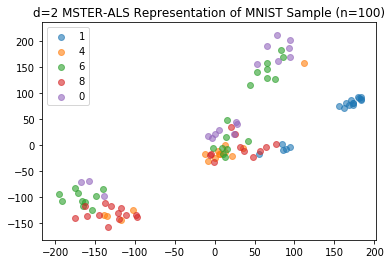

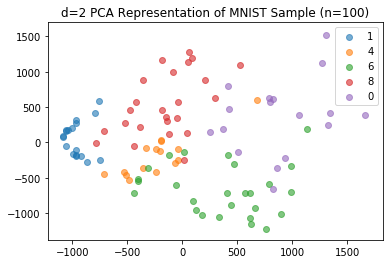

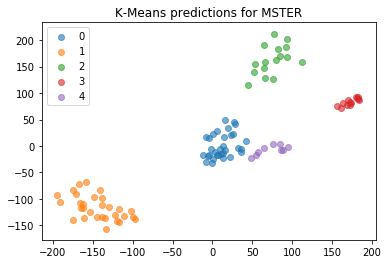

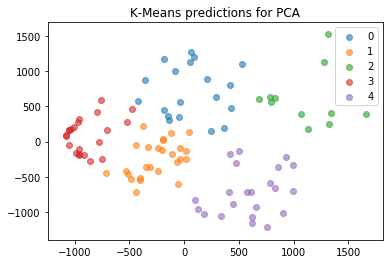

In [1]:
import numpy as np
from sklearn.metrics import pairwise, normalized_mutual_info_score, adjusted_rand_score
import networkx as nx
from matplotlib import pyplot as plt
from optimize.functions import MSTER, LCR, loss, grad, H
from sklearn.cluster import KMeans
from config import MFConfig
import pandas as pd
from sklearn.decomposition import PCA
import copy

num_points = 100
num_clusters = 5
random_state = 1600

df = pd.read_csv('mnist_784_zip/data/mnist_784_csv.csv')
df = df.loc[df['class'].isin([0,1,4,6,8])]
df = df.sample(n=num_points, random_state=random_state)
labels = np.array(df['class'])
data = np.mat(df.drop('class', axis=1))

pca_0 = PCA(n_components = 30) #initial dim reduction for faster MST computation (from tSNE paper)
init_data = np.mat(pca_0.fit_transform(data))
(M, A, B, k_A, lr_a, lr_a_decay, lr_b, lr_b_decay, lambda_, lambda_decay, eta, eta_decay, num_epochs, clip_a, clip_b) = MFConfig(M=init_data).dump()

pca = PCA(n_components = 2)
pca_init = np.mat(pca.fit_transform(init_data))

def train():
    global M, A, B, k_A, lr_a, lr_a_decay, lr_b, lr_b_decay, lambda_, lambda_decay, eta, eta_decay, num_epochs, clip_a, clip_b
    A_best = A.copy()
    B_best = B.copy()

    # ratio_A, vertices_A = MSTER(A, k_A)
    # ratio_B, vertices_B = MSTER(B.T, k_B)
    ratio_A, A_A, B_A, C_A, D_A = LCR(A, k_A)
    loss_best = loss(M,A,B,ratio_A, lambda_, eta)
    for epoch in range(num_epochs):
        best = ''
        if (epoch%10)<5:
            # gradient = (-(M-A*B)*B.T - lambda_*grad(A,vertices_A) - eta*(2*H(M.shape[0]).T*H(M.shape[0])*A))
            gradient = (-(M-A*B)*B.T - lambda_*grad(A,A_A, B_A, C_A, D_A) - eta*(2*H(M.shape[0]).T*H(M.shape[0])*A))
            n = np.linalg.norm(gradient, ord='fro')
            if n > clip_a:
                gradient = clip_a * gradient/n

            A = A - lr_a*gradient
        else:
            gradient = (-A.T*(M-A*B))
            n = np.linalg.norm(gradient, ord='fro')
            if n > clip_b:
                gradient = clip_b * gradient/n

            B = B - lr_b*gradient

        # ratio_A, vertices_A = MSTER(A, k_A)
        # ratio_B, vertices_B = MSTER(B.T, k_B)
        ratio_A, A_A, B_A, C_A, D_A = LCR(A, k_A)
        loss_ = loss(M,A,B,ratio_A, lambda_, eta)

        if loss_<loss_best:
            A_best = A.copy()
            B_best = B.copy()
            best = 'best'
            loss_best = loss_

        lr_a -= lr_a_decay
        lr_b -= lr_b_decay
        lambda_ -= lambda_decay
        eta -= eta_decay

        print("epoch {0} --- \t loss: {1} \t norm contribution: {2} \t {3}".format(epoch,
                loss_, 0.5*np.linalg.norm(M-A*B, ord = 'fro')**2, best))

    return A_best,B_best #returns best model in terms of loss

if __name__ == '__main__':
    A_best, B_best = train()

    ### Dim Reduction
    base = {1: [], 4: [], 6: [], 8: [], 0: []} #{1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: [], 0: []}
    base_kmeans = {0: [], 1: [], 2: [], 3:[], 4:[]}
    legend = [1,4,6,8,0]

    _dict = copy.deepcopy(base)
    for i,row in enumerate(np.array(A_best)):
        _dict[labels[i]].append(row)

    plt.figure(1)
    plt.title('d=2 MSTER-ALS Representation of MNIST Sample (n={})'.format(num_points))
    for i in _dict.keys():
        plt.scatter(np.array(_dict[i])[:,0], np.array(_dict[i])[:,1], alpha=0.6)
    plt.legend(legend)

    _dict2 = copy.deepcopy(base)
    for i,row in enumerate(np.array(pca_init)):
        _dict2[labels[i]].append(row)

    plt.figure(2)
    plt.title('d=2 PCA Representation of MNIST Sample (n={})'.format(num_points))
    for i in _dict2.keys():
        plt.scatter(np.array(_dict2[i])[:,0], np.array(_dict2[i])[:,1], alpha=0.6)
    plt.legend(legend)

    ### KMeans stuff

    predictions_MSTER = KMeans(n_clusters = num_clusters, random_state = random_state).fit(A_best).labels_
    predictions_PCA = KMeans(n_clusters = num_clusters, random_state = random_state).fit(pca_init).labels_

    plt.figure(3)
    plt.title('K-Means predictions for MSTER')
    _dict3 = copy.deepcopy(base_kmeans)
    for i,row in enumerate(np.array(A_best)):
        _dict3[predictions_MSTER[i]].append(row)
    for i in _dict3.keys():
        plt.scatter(np.array(_dict3[i])[:,0], np.array(_dict3[i])[:,1], alpha=0.6)
    plt.legend(range(10))

    plt.figure(4)
    plt.title('K-Means predictions for PCA')
    _dict4 = copy.deepcopy(base_kmeans)
    for i,row in enumerate(np.array(pca_init)):
        _dict4[predictions_PCA[i]].append(row)
    for i in _dict4.keys():
        plt.scatter(np.array(_dict4[i])[:,0], np.array(_dict4[i])[:,1], alpha=0.6)
    plt.legend(range(10))

    ### NMI
    score_MSTER = normalized_mutual_info_score(labels, predictions_MSTER)
    score_PCA = normalized_mutual_info_score(labels, predictions_PCA)

    print("MSTER NMI score: {} \n PCA NMI score: {}".format(score_MSTER, score_PCA))

    ### ARI
    score_MSTER = adjusted_rand_score(labels, predictions_MSTER)
    score_PCA = adjusted_rand_score(labels, predictions_PCA)

    print("MSTER Rand score: {} \n PCA Rand score: {}".format(score_MSTER, score_PCA))

    plt.show()


Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with initial frozen solve. Retrying with flexible solve.

PackagesNotFoundError: The following packages are not available from current channels:

  - optimize

Current channels:

  - https://repo.anaconda.com/pkgs/main/linux-64
  - https://repo.anaconda.com/pkgs/main/noarch
  - https://repo.anaconda.com/pkgs/r/linux-64
  - https://repo.anaconda.com/pkgs/r/noarch

To search for alternate channels that may provide the conda package you're
looking for, navigate to

    https://anaconda.org

and use the search bar at the top of the page.




M: (1000, 30)
A: (1000, 2)
B: (2, 30)
epoch 0 --- 	 loss: 1328784317.0273678 	 norm contribution: 1329805759.7896426 	 
epoch 1 --- 	 loss: 1317565286.2948086 	 norm contribution: 1318864607.207607 	 best
epoch 2 --- 	 loss: 1309306517.8143725 	 norm contribution: 1310622930.1878583 	 best
epoch 3 --- 	 loss: 1302296335.015836 	 norm contribution: 1302844094.8563662 	 best
epoch 4 --- 	 loss: 1295544180.5258336 	 norm contribution: 1296261420.7332375 	 best
epoch 5 --- 	 loss: 1245971794.9028826 	 norm contribution: 1246689178.4436612 	 best
epoch 6 --- 	 loss: 1210862519.2921007 	 norm contribution: 1211580046.1662543 	 best
epoch 7 --- 	 loss: 1186490965.9527006 	 norm contribution: 1187208636.160229 	 best
epoch 8 --- 	 loss: 1167316785.439639 	 norm contribution: 1168034598.9805422 	 best
epoch 9 --- 	 loss: 1150675264.787393 	 norm contribution: 1151393221.661671 	 best
epoch 10 --- 	 loss: 1022574737.4506419 	 norm contribution: 1023502647.2463541 	 best
epoch 11 --- 	 loss: 9841

MSTER NMI score: 0.5605917997319996 
 PCA NMI score: 0.543231943746578
MSTER Rand score: 0.5199303191789066 
 PCA Rand score: 0.5201925897115002


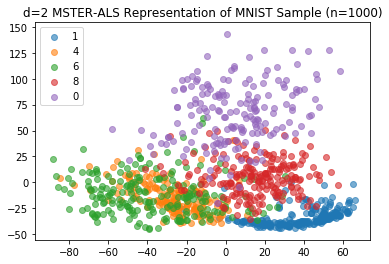

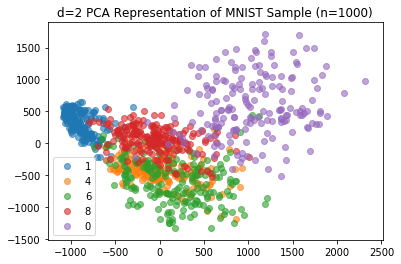

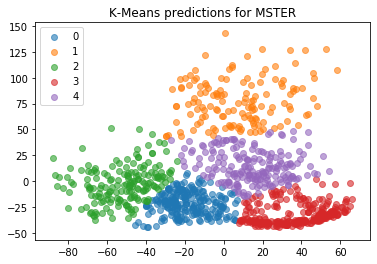

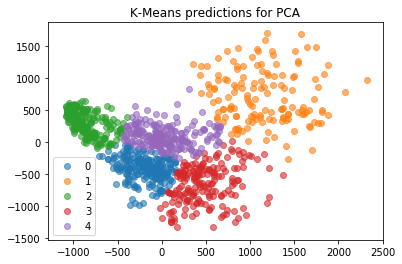

In [1]:
import numpy as np
from sklearn.metrics import pairwise, normalized_mutual_info_score, adjusted_rand_score
import networkx as nx
from matplotlib import pyplot as plt
from optimize.functions import MSTER, LCR, loss, grad, H
from sklearn.cluster import KMeans
from config import MFConfig
import pandas as pd
from sklearn.decomposition import PCA
import copy

num_points = 1000
num_clusters = 5
random_state = 1600

df = pd.read_csv('mnist_784_zip/data/mnist_784_csv.csv')
df = df.loc[df['class'].isin([0,1,4,6,8])]
df = df.sample(n=num_points, random_state=random_state)
labels = np.array(df['class'])
data = np.mat(df.drop('class', axis=1))

pca_0 = PCA(n_components = 30) #initial dim reduction for faster MST computation (from tSNE paper)
init_data = np.mat(pca_0.fit_transform(data))
(M, A, B, k_A, lr_a, lr_a_decay, lr_b, lr_b_decay, lambda_, lambda_decay, eta, eta_decay, num_epochs, clip_a, clip_b) = MFConfig(M=init_data).dump()

pca = PCA(n_components = 2)
pca_init = np.mat(pca.fit_transform(init_data))

def train():
    global M, A, B, k_A, lr_a, lr_a_decay, lr_b, lr_b_decay, lambda_, lambda_decay, eta, eta_decay, num_epochs, clip_a, clip_b
    A_best = A.copy()
    B_best = B.copy()

    # ratio_A, vertices_A = MSTER(A, k_A)
    # ratio_B, vertices_B = MSTER(B.T, k_B)
    ratio_A, A_A, B_A, C_A, D_A = LCR(A, k_A)
    loss_best = loss(M,A,B,ratio_A, lambda_, eta)
    for epoch in range(num_epochs):
        best = ''
        if (epoch%10)<5:
            # gradient = (-(M-A*B)*B.T - lambda_*grad(A,vertices_A) - eta*(2*H(M.shape[0]).T*H(M.shape[0])*A))
            gradient = (-(M-A*B)*B.T - lambda_*grad(A,A_A, B_A, C_A, D_A) - eta*(2*H(M.shape[0]).T*H(M.shape[0])*A))
            n = np.linalg.norm(gradient, ord='fro')
            if n > clip_a:
                gradient = clip_a * gradient/n

            A = A - lr_a*gradient
        else:
            gradient = (-A.T*(M-A*B))
            n = np.linalg.norm(gradient, ord='fro')
            if n > clip_b:
                gradient = clip_b * gradient/n

            B = B - lr_b*gradient

        # ratio_A, vertices_A = MSTER(A, k_A)
        # ratio_B, vertices_B = MSTER(B.T, k_B)
        ratio_A, A_A, B_A, C_A, D_A = LCR(A, k_A)
        loss_ = loss(M,A,B,ratio_A, lambda_, eta)

        if loss_<loss_best:
            A_best = A.copy()
            B_best = B.copy()
            best = 'best'
            loss_best = loss_

        lr_a -= lr_a_decay
        lr_b -= lr_b_decay
        lambda_ -= lambda_decay
        eta -= eta_decay

        print("epoch {0} --- \t loss: {1} \t norm contribution: {2} \t {3}".format(epoch,
                loss_, 0.5*np.linalg.norm(M-A*B, ord = 'fro')**2, best))

    return A_best,B_best #returns best model in terms of loss

if __name__ == '__main__':
    A_best, B_best = train()

    ### Dim Reduction
    base = {1: [], 4: [], 6: [], 8: [], 0: []} #{1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: [], 0: []}
    base_kmeans = {0: [], 1: [], 2: [], 3:[], 4:[]}
    legend = [1,4,6,8,0]

    _dict = copy.deepcopy(base)
    for i,row in enumerate(np.array(A_best)):
        _dict[labels[i]].append(row)

    plt.figure(1)
    plt.title('d=2 MSTER-ALS Representation of MNIST Sample (n={})'.format(num_points))
    for i in _dict.keys():
        plt.scatter(np.array(_dict[i])[:,0], np.array(_dict[i])[:,1], alpha=0.6)
    plt.legend(legend)

    _dict2 = copy.deepcopy(base)
    for i,row in enumerate(np.array(pca_init)):
        _dict2[labels[i]].append(row)

    plt.figure(2)
    plt.title('d=2 PCA Representation of MNIST Sample (n={})'.format(num_points))
    for i in _dict2.keys():
        plt.scatter(np.array(_dict2[i])[:,0], np.array(_dict2[i])[:,1], alpha=0.6)
    plt.legend(legend)

    ### KMeans stuff

    predictions_MSTER = KMeans(n_clusters = num_clusters, random_state = random_state).fit(A_best).labels_
    predictions_PCA = KMeans(n_clusters = num_clusters, random_state = random_state).fit(pca_init).labels_

    plt.figure(3)
    plt.title('K-Means predictions for MSTER')
    _dict3 = copy.deepcopy(base_kmeans)
    for i,row in enumerate(np.array(A_best)):
        _dict3[predictions_MSTER[i]].append(row)
    for i in _dict3.keys():
        plt.scatter(np.array(_dict3[i])[:,0], np.array(_dict3[i])[:,1], alpha=0.6)
    plt.legend(range(10))

    plt.figure(4)
    plt.title('K-Means predictions for PCA')
    _dict4 = copy.deepcopy(base_kmeans)
    for i,row in enumerate(np.array(pca_init)):
        _dict4[predictions_PCA[i]].append(row)
    for i in _dict4.keys():
        plt.scatter(np.array(_dict4[i])[:,0], np.array(_dict4[i])[:,1], alpha=0.6)
    plt.legend(range(10))

    ### NMI
    score_MSTER = normalized_mutual_info_score(labels, predictions_MSTER)
    score_PCA = normalized_mutual_info_score(labels, predictions_PCA)

    print("MSTER NMI score: {} \n PCA NMI score: {}".format(score_MSTER, score_PCA))

    ### ARI
    score_MSTER = adjusted_rand_score(labels, predictions_MSTER)
    score_PCA = adjusted_rand_score(labels, predictions_PCA)

    print("MSTER Rand score: {} \n PCA Rand score: {}".format(score_MSTER, score_PCA))

    plt.show()


In [ ]:
import numpy as np
from sklearn.metrics import pairwise, normalized_mutual_info_score, adjusted_rand_score
import networkx as nx
from matplotlib import pyplot as plt
from optimize.functions import MSTER, LCR, loss, grad, H
from sklearn.cluster import KMeans
from config import MFConfig
import pandas as pd
from sklearn.decomposition import PCA
import copy

num_points = 5000
num_clusters = 5
random_state = 1600

df = pd.read_csv('mnist_784_zip/data/mnist_784_csv.csv')
df = df.loc[df['class'].isin([0,1,4,6,8])]
df = df.sample(n=num_points, random_state=random_state)
labels = np.array(df['class'])
data = np.mat(df.drop('class', axis=1))

pca_0 = PCA(n_components = 30) #initial dim reduction for faster MST computation (from tSNE paper)
init_data = np.mat(pca_0.fit_transform(data))
(M, A, B, k_A, lr_a, lr_a_decay, lr_b, lr_b_decay, lambda_, lambda_decay, eta, eta_decay, num_epochs, clip_a, clip_b) = MFConfig(M=init_data).dump()

pca = PCA(n_components = 2)
pca_init = np.mat(pca.fit_transform(init_data))

def train():
    global M, A, B, k_A, lr_a, lr_a_decay, lr_b, lr_b_decay, lambda_, lambda_decay, eta, eta_decay, num_epochs, clip_a, clip_b
    A_best = A.copy()
    B_best = B.copy()

    # ratio_A, vertices_A = MSTER(A, k_A)
    # ratio_B, vertices_B = MSTER(B.T, k_B)
    ratio_A, A_A, B_A, C_A, D_A = LCR(A, k_A)
    loss_best = loss(M,A,B,ratio_A, lambda_, eta)
    for epoch in range(num_epochs):
        best = ''
        if (epoch%10)<5:
            # gradient = (-(M-A*B)*B.T - lambda_*grad(A,vertices_A) - eta*(2*H(M.shape[0]).T*H(M.shape[0])*A))
            gradient = (-(M-A*B)*B.T - lambda_*grad(A,A_A, B_A, C_A, D_A) - eta*(2*H(M.shape[0]).T*H(M.shape[0])*A))
            n = np.linalg.norm(gradient, ord='fro')
            if n > clip_a:
                gradient = clip_a * gradient/n

            A = A - lr_a*gradient
        else:
            gradient = (-A.T*(M-A*B))
            n = np.linalg.norm(gradient, ord='fro')
            if n > clip_b:
                gradient = clip_b * gradient/n

            B = B - lr_b*gradient

        # ratio_A, vertices_A = MSTER(A, k_A)
        # ratio_B, vertices_B = MSTER(B.T, k_B)
        ratio_A, A_A, B_A, C_A, D_A = LCR(A, k_A)
        loss_ = loss(M,A,B,ratio_A, lambda_, eta)

        if loss_<loss_best:
            A_best = A.copy()
            B_best = B.copy()
            best = 'best'
            loss_best = loss_

        lr_a -= lr_a_decay
        lr_b -= lr_b_decay
        lambda_ -= lambda_decay
        eta -= eta_decay

        print("epoch {0} --- \t loss: {1} \t norm contribution: {2} \t {3}".format(epoch,
                loss_, 0.5*np.linalg.norm(M-A*B, ord = 'fro')**2, best))

    return A_best,B_best #returns best model in terms of loss

if __name__ == '__main__':
    A_best, B_best = train()

    ### Dim Reduction
    base = {1: [], 4: [], 6: [], 8: [], 0: []} #{1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: [], 0: []}
    base_kmeans = {0: [], 1: [], 2: [], 3:[], 4:[]}
    legend = [1,4,6,8,0]

    _dict = copy.deepcopy(base)
    for i,row in enumerate(np.array(A_best)):
        _dict[labels[i]].append(row)

    plt.figure(1)
    plt.title('d=2 MSTER-ALS Representation of MNIST Sample (n={})'.format(num_points))
    for i in _dict.keys():
        plt.scatter(np.array(_dict[i])[:,0], np.array(_dict[i])[:,1], alpha=0.6)
    plt.legend(legend)

    _dict2 = copy.deepcopy(base)
    for i,row in enumerate(np.array(pca_init)):
        _dict2[labels[i]].append(row)

    plt.figure(2)
    plt.title('d=2 PCA Representation of MNIST Sample (n={})'.format(num_points))
    for i in _dict2.keys():
        plt.scatter(np.array(_dict2[i])[:,0], np.array(_dict2[i])[:,1], alpha=0.6)
    plt.legend(legend)

    ### KMeans stuff

    predictions_MSTER = KMeans(n_clusters = num_clusters, random_state = random_state).fit(A_best).labels_
    predictions_PCA = KMeans(n_clusters = num_clusters, random_state = random_state).fit(pca_init).labels_

    plt.figure(3)
    plt.title('K-Means predictions for MSTER')
    _dict3 = copy.deepcopy(base_kmeans)
    for i,row in enumerate(np.array(A_best)):
        _dict3[predictions_MSTER[i]].append(row)
    for i in _dict3.keys():
        plt.scatter(np.array(_dict3[i])[:,0], np.array(_dict3[i])[:,1], alpha=0.6)
    plt.legend(range(10))

    plt.figure(4)
    plt.title('K-Means predictions for PCA')
    _dict4 = copy.deepcopy(base_kmeans)
    for i,row in enumerate(np.array(pca_init)):
        _dict4[predictions_PCA[i]].append(row)
    for i in _dict4.keys():
        plt.scatter(np.array(_dict4[i])[:,0], np.array(_dict4[i])[:,1], alpha=0.6)
    plt.legend(range(10))

    ### NMI
    score_MSTER = normalized_mutual_info_score(labels, predictions_MSTER)
    score_PCA = normalized_mutual_info_score(labels, predictions_PCA)

    print("MSTER NMI score: {} \n PCA NMI score: {}".format(score_MSTER, score_PCA))

    ### ARI
    score_MSTER = adjusted_rand_score(labels, predictions_MSTER)
    score_PCA = adjusted_rand_score(labels, predictions_PCA)

    print("MSTER Rand score: {} \n PCA Rand score: {}".format(score_MSTER, score_PCA))

    plt.show()


M: (5000, 30)
A: (5000, 2)
B: (2, 30)
epoch 0 --- 	 loss: 6521608164.1841955 	 norm contribution: 6522410546.705613 	 best
epoch 1 --- 	 loss: 6488067406.085121 	 norm contribution: 6488708601.916718 	 best
epoch 2 --- 	 loss: 6459765560.231921 	 norm contribution: 6460472595.587709 	 best
epoch 3 --- 	 loss: 6435516022.017316 	 norm contribution: 6436306582.36886 	 best
epoch 4 --- 	 loss: 6413449790.8199215 	 norm contribution: 6414569438.010465 	 best
epoch 5 --- 	 loss: 6170889850.973372 	 norm contribution: 6172009721.914353 	 best
epoch 6 --- 	 loss: 6009552991.074392 	 norm contribution: 6010673085.765811 	 best
epoch 7 --- 	 loss: 5916879647.239645 	 norm contribution: 5917999965.681501 	 best
epoch 8 --- 	 loss: 5855483201.121354 	 norm contribution: 5856603743.313648 	 best
epoch 9 --- 	 loss: 5801705351.756036 	 norm contribution: 5802826117.698768 	 best
epoch 10 --- 	 loss: 5527832252.443273 	 norm contribution: 5528413934.233003 	 best
epoch 11 --- 	 loss: 5338012677.3076

hello
